# LangGraph 기본 구성요소

1. `State`
2. `Nodes`
3. `Edges`

## 1. `State`

> Graph의 현재 상태를 나타내는 데이터 구조

> 주로 `TypedDict`, pydantic `BaseModel` 로 정의할 수 있음

### 1-1. State 정의하기

In [10]:
# Define State with TypedDict

from typing import TypedDict

class State(TypedDict):
    id: int
    name: str
    email: str

state_data = {
    'id' : 1,
    'name' : 'martinus_choi',
    'email' : 'martinus.choi@gmail.com'
}
state_1 = State(**state_data)

state_data: State = {
    'id' : 2,
    'name' : 123,
    'email' : 'martinus.choi@gmail.com'
}
state_2 = State(**state_data)

print(state_1)
print(state_2)

{'id': 1, 'name': 'martinus_choi', 'email': 'martinus.choi@gmail.com'}
{'id': 2, 'name': 123, 'email': 'martinus.choi@gmail.com'}


`TypedDict`는 데이터 유효성 검사를 수행하지 않음, 미리 지정한 타입의 데이터가 들어오지 않아도 에러가 발생하지 않음

In [8]:
# Define State with pydantic BaseModel

from pydantic import BaseModel

class State(BaseModel):
    id: int
    name: str
    email: str

state_data = {
    'id' : 1,
    'name' : 'martinus_choi',
    'email' : 'martinus.choi@gmail.com'
}
state_1 = State(**state_data)

print(state_1)

id=1 name='martinus_choi' email='martinus.choi@gmail.com'


In [9]:
state_data: State = {
    'id' : 2,
    'name' : 123,
    'email' : 'martinus.choi@gmail.com'
}
state_2 = State(**state_data)

print(state_2)

ValidationError: 1 validation error for State
name
  Input should be a valid string [type=string_type, input_value=123, input_type=int]
    For further information visit https://errors.pydantic.dev/2.9/v/string_type

pydantic `BaseModel`은 데이터 유효성 검사를 수행하기 때문에, 미리 지정한 데이터 타입의 데이터가 들어오지 않으면 에러가 발생함

### 1-2. Graph Schema 지정하기

> Graph에서 사용할 State의 구조를 미리 지정함

> 추가로 입력 State의 구조와 출력 State의 구조를 지정할 수 도 있음 

In [6]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict

# Define Input Schema
class InputState(TypedDict):
    question: str

# Define Output Schema
class OutputState(TypedDict):
    answer: str

# Define Graph State Schema
class OverallState(InputState, OutputState):
    id: int

In [7]:
# Define Node
def answer_node(state: InputState):
    new_state = {
        "answer" : "bye",
        "id" : 0,
        "question" : state["question"]
    }

    print(new_state)

    return new_state 

In [ ]:
# input : set input state schema
# output : set output state schema
workflow = StateGraph(OverallState, input=InputState, output=OutputState)

# add nodes
workflow.add_node(answer_node, "answer_node")

# add edges
workflow.add_edge(START, "answer_node")
workflow.add_edge("answer_node", END)

# compile graph
app = workflow.compile()

In [9]:
print(app.invoke({"question" : "hi"}))

{'answer': 'bye', 'id': 0, 'question': 'hi'}
{'answer': 'bye'}


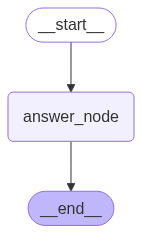

In [10]:
app

### 1-3. Reducer 지정하기

> 리듀서(Reducer) : 노드에서 수행되는 작업을 통해 State에 적용되는 업데이트가 어떻게 적용될 지 지정하는 함수

- Annotated는 타입 + 메타데이터(여기서는 reducer 함수)를 결합하는 역할만 함
- 실제로 상태 업데이트 시 reducer(operator.add 등)는 LangGraph가 읽어서 동작 방식(덮어쓰기 vs. 누적 등)을 결정함
- Annotated 자체는 동작을 수행하지 않음. 동작의 주체는 LangGraph임

In [11]:
# without Reducer
from typing_extensions import TypedDict

class State(TypedDict):
    value_1: int
    value_2: list[str]

In [12]:
# with Reducer (operator.add)
from typing_extensions import TypedDict
from typing import Annotated
from operator import add

class State(TypedDict):
    value_1: int
    value_2: Annotated[list[str], add]

In [13]:
# with Reducer (custom add)
from typing_extensions import TypedDict
from typing import Annotated

def add(left, right):
    return left + right

class State(TypedDict):
    value_1: int
    value_2: Annotated[list[str], add]

In [14]:
# with Reducer (add_messages)
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated

class State(TypedDict):
    value_1: int
    messages: Annotated[list[AnyMessage], add_messages]

# 2. `Nodes`

### 2-1. Node를 그래프에 추가하기 (`add_node`)

In [32]:
from typing_extensions import TypedDict

class InputState(TypedDict):
    user_query: str

class OutputState(TypedDict):
    result: str

class GraphState(InputState, OutputState):
    pass

def node_1(state: InputState):
    print(f"Node 1 : {state}")
    return {
        'result' : state['user_query'] + '_node_1'
    }

def node_2(state: GraphState):
    print(f"Node 2 : {state}")
    return {
        'result' : state['result'] + '_node_2'
    }

In [33]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(
    GraphState,
    input=InputState,
    output=OutputState
)

workflow.add_node("node_1", node_1)
workflow.add_node("node_2", node_2)

workflow.add_edge(START, "node_1")
workflow.add_edge("node_1", "node_2")
workflow.add_edge("node_2", END)

app = workflow.compile()

In [34]:
print(app.invoke({"user_query" : "hello"}))

Node 1 : {'user_query': 'hello'}
Node 2 : {'user_query': 'hello', 'result': 'hello_node_1'}
{'result': 'hello_node_1_node_2'}


### 1-2. Node의 기능 구현하기

In [35]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_core.messages import (
    HumanMessage,
    AIMessage,
    AnyMessage
)
from langgraph.graph.message import add_messages

class InputState(TypedDict):
    query: str

class OutputState(TypedDict):
    answer: str

class GraphState(InputState, OutputState):
    messages: Annotated[list[AnyMessage], add_messages]

In [46]:
def chatbot_node(state: InputState):
    query = state['query']
    user_message = HumanMessage(content=query)
    
    answer = "무엇을 도와드릴까요?"
    ai_message = AIMessage(content=answer)

    return {
        'answer' : answer,
        'messages' : [user_message, ai_message]
    }

def show_messages_node(state: GraphState):
    for message in state["messages"]:
        print(message)

    return state

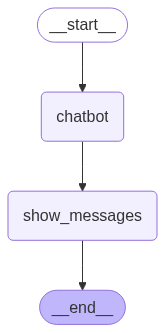

In [47]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(
    GraphState,
    input=InputState,
    output=OutputState
)

workflow.add_node("chatbot", chatbot_node)
workflow.add_node("show_messages", show_messages_node)

workflow.add_edge(START, "chatbot")
workflow.add_edge("chatbot", "show_messages")
workflow.add_edge("show_messages", END)

app = workflow.compile()

app

In [48]:
app.invoke({"query" : "안녕"})

content='안녕' additional_kwargs={} response_metadata={} id='52f8277e-c0c5-48cf-86be-0af364b086f8'
content='무엇을 도와드릴까요?' additional_kwargs={} response_metadata={} id='aa885eec-3031-4a41-87a7-e9152009147d'


{'answer': '무엇을 도와드릴까요?'}

## 3. `Edges`

> 기본적인 엣지는 `.add_edge("node_a", "node_b")` 메서드를 통해 추가할 수 있다.
>> 매개변수로 전달되는 것은 노드의 이름이다.

### 3-1. 조건부 엣지로 Routing 하기

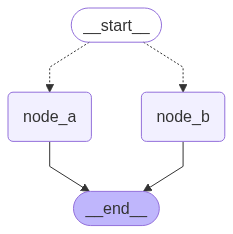

In [49]:
from typing_extensions import TypedDict

# Define State
class State(TypedDict):
    input_val: str
    output_val: str

# Define Nodes
def node_a(state: State):
    return {
        "output_val" : "a"
    }

def node_b(state: State):
    return {
        "output_val" : "b"
    }

# Define Edges
def routing_function(state: State):
    if state['input_val'] == "a":
        return "node_a"
    else:
        return "node_b"


# Define Grpah Builder
workflow = StateGraph(State)

# Add nodes
workflow.add_node("node_a", node_a)
workflow.add_node("node_b", node_b)

# add edges
workflow.add_conditional_edges(
    START,
    routing_function,
    {
        "node_a" : "node_a",
        "node_b" : "node_b"
    }
)
workflow.add_edge("node_a", END)
workflow.add_edge("node_b", END)

# Compile Graph
app = workflow.compile()

app

In [50]:
app.invoke({"input_val" : "a"})

{'input_val': 'a', 'output_val': 'a'}

In [52]:
app.invoke({"input_val" : "b"})

{'input_val': 'b', 'output_val': 'b'}